# Hyperparameter tuning

To improve the performance of our model, we need to delve into the realm of hyperparameter tuning. Hyperparameters are settings that we can adjust to optimize the behavior and accuracy of our machine learning model, to fine-tune it's performance. 

The previous model was trained with certain default hyperparameter values, which serve as a baseline. However, these default values may not always yield the best results for our specific problem.

Hyperparameter tuning involves systematically exploring different combinations of hyperparameter values to find the optimal configuration that maximizes our model's performance. This process is often iterative and involves training and evaluating the model multiple times with different hyperparameter settings.

In [1]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
MAX_LR = 1e-4
TRAIN_SIZE = 320
VAL_SIZE = 320
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
EPOCHS = 24
LOAD_BEST = True
NAME = "4 - LR1e-4 TrainBatch8 Epoch24"

DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
DATA_PATH = OUTPUT_PATH + "data/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

We'll reimport the default values that we had from before

We slightly modified the values of the transformations! We're having a better alignment, and using A.RandomCrop is better than A.Resize because you don't loose details

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902
Image shape: torch.Size([8, 3, 320, 320]), Mask shape: torch.Size([8, 1, 320, 320])


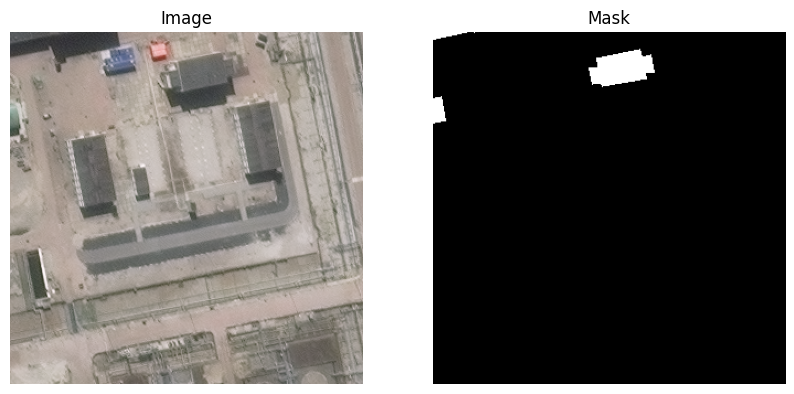

In [3]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())


train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.RandomCrop(TRAIN_SIZE, TRAIN_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.RandomCrop(VAL_SIZE, VAL_SIZE)
])
from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')
test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')

train_loader = data.DataLoader(train_dataset, pin_memory = True, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [4]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()


One of the things I've noticed in the training is how hard it's for the model to track small buildings, this is because to make our batch_size higher a downscale was necessary; we modified some values, changing:
 - SIZE to 300x300
 - BATCH_SIZE to 8

In [5]:
from train import train

best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'last_epoch': 0 
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + f"best_{NAME}.pth")):
        history = utils.load_checkpoint(CHECKPOINT_PATH + f"best_{NAME}.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
        last_epoch = history['last_epoch']
        print(f"Best model found, starting from epoch {last_epoch+1} with f1_score {best_f1}")
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path=DATA_PATH)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    history['last_epoch'] = epoch
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"checkpoint_{NAME}.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"best_{NAME}.pth")
        print("Best model saved")

    if epoch - 5 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2] > history['val_loss'][epoch-3] > history['val_loss'][epoch-4]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

Restoring best model
Best model not found, starting from scratch
Epoch 1 of 24


Loss: 0.4406: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.5972 Eval loss: 0.4896 Precision: 0.3708 Recall: 0.7057 F1: 0.4861 Accuracy: 0.8883
saving checkpoint
saving checkpoint
Best model saved
Epoch 2 of 24


Loss: 0.3667: 100%|██████████| 340/340 [01:40<00:00,  3.37it/s]

Saving predictions to: output/data/


Train loss: 0.4102 Eval loss: 0.3662 Precision: 0.5037 Recall: 0.6650 F1: 0.5732 Accuracy: 0.9268
saving checkpoint
saving checkpoint
Best model saved
Epoch 3 of 24


Loss: 0.2921: 100%|██████████| 340/340 [01:40<00:00,  3.37it/s]

Saving predictions to: output/data/


Train loss: 0.3452 Eval loss: 0.2906 Precision: 0.8031 Recall: 0.4064 F1: 0.5397 Accuracy: 0.9454
saving checkpoint
Epoch 4 of 24


Loss: 0.2338: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.2926 Eval loss: 0.2452 Precision: 0.7741 Recall: 0.4981 F1: 0.6061 Accuracy: 0.9447
saving checkpoint
saving checkpoint
Best model saved
Epoch 5 of 24


Loss: 0.2646: 100%|██████████| 340/340 [01:44<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.2398 Eval loss: 0.1876 Precision: 0.6752 Recall: 0.6885 F1: 0.6818 Accuracy: 0.9505
saving checkpoint
saving checkpoint
Best model saved
Epoch 6 of 24


Loss: 0.1419: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.2060 Eval loss: 0.1775 Precision: 0.7712 Recall: 0.4927 F1: 0.6013 Accuracy: 0.9524
saving checkpoint
Epoch 7 of 24


Loss: 0.2900: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.1770 Eval loss: 0.1469 Precision: 0.6776 Recall: 0.6791 F1: 0.6783 Accuracy: 0.9499
saving checkpoint
Epoch 8 of 24


Loss: 0.1456: 100%|██████████| 340/340 [01:41<00:00,  3.34it/s]

Saving predictions to: output/data/


Train loss: 0.1551 Eval loss: 0.1350 Precision: 0.8058 Recall: 0.5603 F1: 0.6610 Accuracy: 0.9575
saving checkpoint
Epoch 9 of 24


Loss: 0.1981: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.1439 Eval loss: 0.1645 Precision: 0.5800 Recall: 0.7497 F1: 0.6540 Accuracy: 0.9397
saving checkpoint
Epoch 10 of 24


Loss: 0.1094: 100%|██████████| 340/340 [01:40<00:00,  3.39it/s]

Saving predictions to: output/data/


Train loss: 0.1403 Eval loss: 0.1201 Precision: 0.8062 Recall: 0.5822 F1: 0.6762 Accuracy: 0.9565
saving checkpoint
Epoch 11 of 24


Loss: 0.0534: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.1269 Eval loss: 0.1052 Precision: 0.8348 Recall: 0.6490 F1: 0.7303 Accuracy: 0.9609
saving checkpoint
saving checkpoint
Best model saved
Epoch 12 of 24


Loss: 0.1708: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.1176 Eval loss: 0.1040 Precision: 0.8537 Recall: 0.6060 F1: 0.7088 Accuracy: 0.9613
saving checkpoint
Epoch 13 of 24


Loss: 0.0443: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.1169 Eval loss: 0.0971 Precision: 0.8635 Recall: 0.6135 F1: 0.7174 Accuracy: 0.9640
saving checkpoint
Epoch 14 of 24


Loss: 0.1015:  34%|███▍      | 117/340 [00:35<01:08,  3.28it/s]

In [ ]:
import matplotlib.pyplot as plt

# Get the history
history = utils.load_checkpoint(CHECKPOINT_PATH + f"checkpoint_{NAME}.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + f"image_{NAME}.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, history['last_epoch']+1))    
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.xticks(range(1, history['last_epoch']+1))   
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + f"metrics_{NAME}.png")
plt.show()